<!-- # Analysis and Design of Multi-Layer Neural Networks (MLP)

## Table of Contents
- [MLP Design](#mlp-design)
- [Train Two Different Models](#train-two-different-models)
- [Back Propagation Algorithm](#back-propagation-algorithm)
- [Analysis of Different Hyperparameters](#analysis-of-different-hyperparameters)
- [References](#references) -->

## Import Libraries

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim

## Utils

In [106]:
def plot_weight_histogram(model, layer_name, title='Weight Histogram'):
    plt.figure(figsize=(5, 3))
    weights = getattr(model, layer_name).weight.detach().cpu().numpy().flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight")
    plt.ylabel("Frequency")
    plt.show()

def sub_plot(epochs, data, p_label, title, y_label):
    plt.plot(epochs, data, 'bo-', label=p_label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()

def plot_train_results(m):
    train_losses = m.train_losses
    train_accuracies = m.train_accuracies
    num_epochs = len(train_losses)
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    sub_plot(epochs, train_losses, 'Training Loss', title='Training Loss', y_label='Loss')

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    sub_plot(epochs, train_accuracies, 'Training Accuracy', title='Training Accuracy', y_label='Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    return cm

def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def format(accuracy): 
    return f"{accuracy:.3f}"

def plot_curve(results, what, label, y_label, title):
    for metric, history in results.items():
        data = history[what]
        plt.plot(data, label=label+f'{metric})')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()



In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

np.random.seed(42)
torch.manual_seed(42)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cuda


In [61]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

one issue was I tried to set the transformer this lambda bellow and the test loss was unbelievable!

## Dataset

In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] 
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

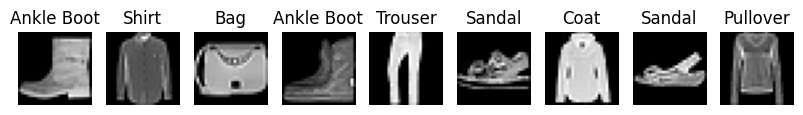

In [63]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 9,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## MLP Design

In [97]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate)
        for _ in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)

    def fit(self, train_loader, test_loader, num_epochs):
        for _ in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)


In [100]:
m = MLP(Model(100, do_rate=0.3), nn.CrossEntropyLoss())

In [101]:
num_epochs = 30

for epoch in range(num_epochs):
    train_loss, train_acc = m.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/30], Train Loss: 1.4166, Train Acc: 0.5744
Epoch [2/30], Train Loss: 0.8715, Train Acc: 0.7063
Epoch [3/30], Train Loss: 0.7471, Train Acc: 0.7379
Epoch [4/30], Train Loss: 0.6881, Train Acc: 0.7583
Epoch [5/30], Train Loss: 0.6503, Train Acc: 0.7698
Epoch [6/30], Train Loss: 0.6204, Train Acc: 0.7828
Epoch [7/30], Train Loss: 0.5955, Train Acc: 0.7911
Epoch [8/30], Train Loss: 0.5787, Train Acc: 0.7964
Epoch [9/30], Train Loss: 0.5617, Train Acc: 0.8027
Epoch [10/30], Train Loss: 0.5504, Train Acc: 0.8070
Epoch [11/30], Train Loss: 0.5378, Train Acc: 0.8099
Epoch [12/30], Train Loss: 0.5266, Train Acc: 0.8149
Epoch [13/30], Train Loss: 0.5173, Train Acc: 0.8171
Epoch [14/30], Train Loss: 0.5109, Train Acc: 0.8196
Epoch [15/30], Train Loss: 0.5035, Train Acc: 0.8241
Epoch [16/30], Train Loss: 0.4958, Train Acc: 0.8255
Epoch [17/30], Train Loss: 0.4910, Train Acc: 0.8276
Epoch [18/30], Train Loss: 0.4853, Train Acc: 0.8290
Epoch [19/30], Train Loss: 0.4804, Train Acc: 0.8305
Ep

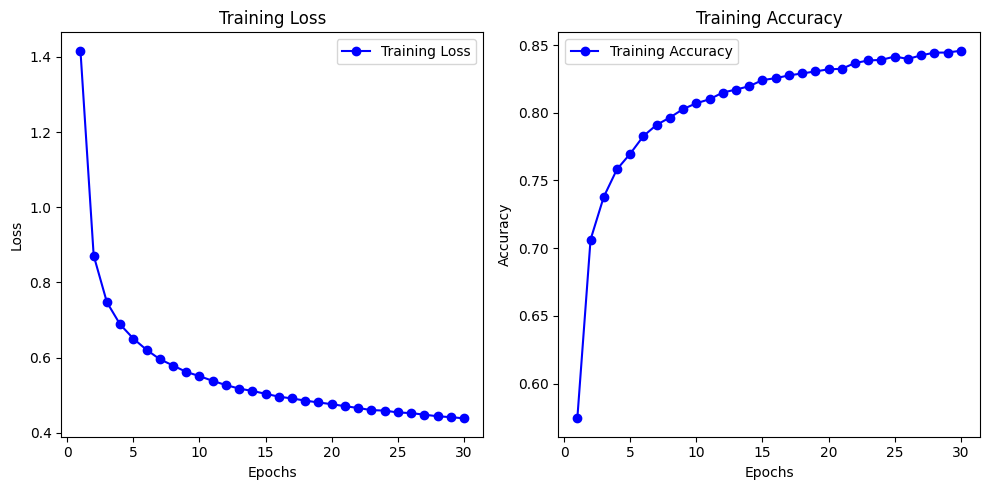

In [102]:
plot_train_results(m)

In [104]:
_, _ = m.evaluate(train_loader)
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.85      0.82      6000
     Trouser       0.98      0.96      0.97      6000
    Pullover       0.75      0.79      0.77      6000
       Dress       0.86      0.88      0.87      6000
        Coat       0.77      0.77      0.77      6000
      Sandal       0.93      0.92      0.93      6000
       Shirt       0.68      0.59      0.63      6000
     Sneaker       0.91      0.91      0.91      6000
         Bag       0.95      0.95      0.95      6000
  Ankle boot       0.92      0.94      0.93      6000

    accuracy                           0.86     60000
   macro avg       0.86      0.86      0.86     60000
weighted avg       0.86      0.86      0.86     60000



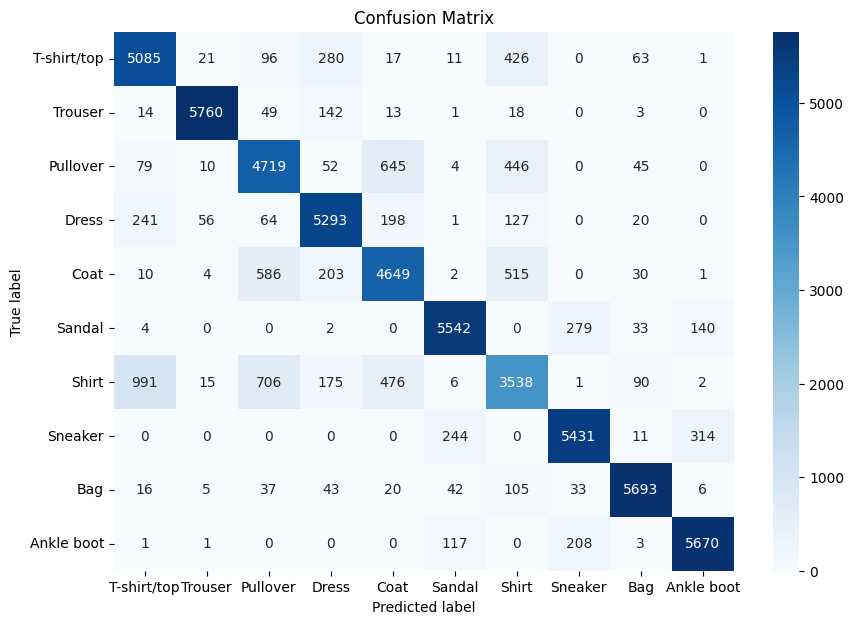

In [105]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [ ]:
test_loss, _ = m.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m.all_labels, m.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4389
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.74      0.74      0.74      1000
       Dress       0.83      0.86      0.85      1000
        Coat       0.73      0.77      0.75      1000
      Sandal       0.94      0.89      0.91      1000
       Shirt       0.64      0.57      0.60      1000
     Sneaker       0.89      0.91      0.90      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.91      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



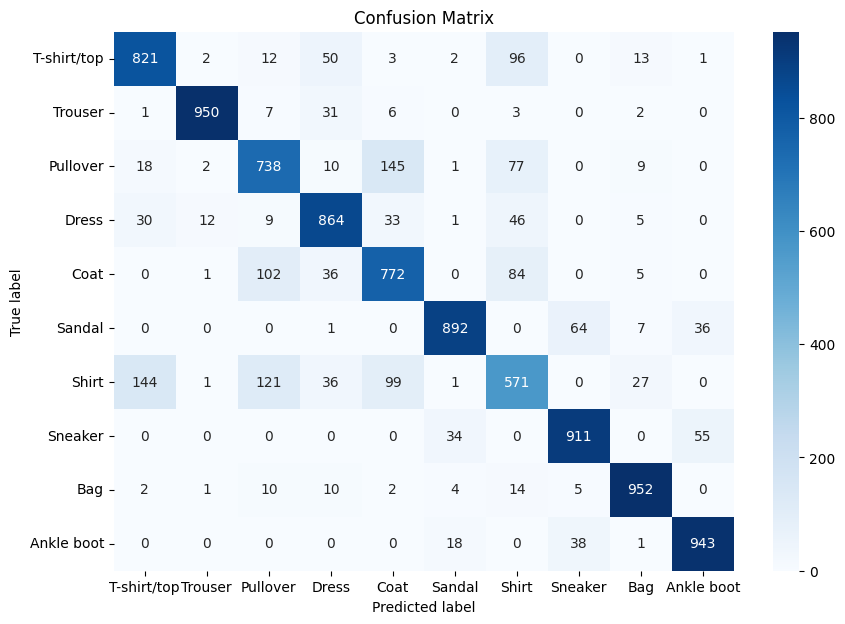

In [ ]:
cm = plot_confusion_matrix(m.all_labels, m.all_preds, class_names)

In [ ]:
most_confused = {}
for i in range(10):
    row = cm[i]
    row[i] = 0
    most_confused_class = np.argmax(row)
    most_confused[i] = most_confused_class

for m in range(10):
    print(f"Class `{class_names[m]}` is most often confused with class `{class_names[most_confused[m]]}`")

Class `T-shirt/top` is most often confused with class `Shirt`
Class `Trouser` is most often confused with class `Dress`
Class `Pullover` is most often confused with class `Coat`
Class `Dress` is most often confused with class `Shirt`
Class `Coat` is most often confused with class `Pullover`
Class `Sandal` is most often confused with class `Sneaker`
Class `Shirt` is most often confused with class `T-shirt/top`
Class `Sneaker` is most often confused with class `Ankle boot`
Class `Bag` is most often confused with class `Shirt`
Class `Ankle boot` is most often confused with class `Sneaker`


In [ ]:
conf_matrix_copy = cm.copy()
np.fill_diagonal(conf_matrix_copy, 0)  # Zero the diagonal

most_common_confusion = np.unravel_index(np.argmax(conf_matrix_copy), conf_matrix_copy.shape)

# Print the most commonly confused classes
print(f"The two most commonly confused classes are: `{class_names[most_common_confusion[0]]}` with `{class_names[most_common_confusion[1]]}`.")


The two most commonly confused classes are: `Pullover` with `Coat`.


#### Impact of Increasing Model Complexity

#### Criteria for Choosing the Best Configuration

- **Validation performance** : Monitor the validation accuracy and loss to ensure the model generalizes well.
- **Training stability** : Ensure that the model does not exhibit overfitting (training accuracy much higher than validation accuracy) or underfitting (both training and validation accuracies are low).
- **Computational efficiency** : Balance model complexity with computational resources (training time, memory usage).
- **Regularization** : Ensure proper regularization (e.g., dropout, L2 regularization) to prevent overfitting.

We can tune hyperparameters such as the number of layers, number of neurons per layer, regularization techniques, and learning rate to find the best configuration.

## Train Two Different Models

In [118]:
cirteria = nn.CrossEntropyLoss()

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [119]:
model1 = Model(128)
model1.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)>

In [120]:
model2 = Model(48, 0.2)
model2.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=784, out_features=48, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=48, out_features=10, bias=True)
)>

In [121]:
m1 = MLP(model1, cirteria)
m2 = MLP(model2, cirteria, lambda_reg=0.0001)

In [122]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m1.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.3471, Train Acc: 0.6387
Epoch [2/40], Train Loss: 0.7795, Train Acc: 0.7470
Epoch [3/40], Train Loss: 0.6613, Train Acc: 0.7718
Epoch [4/40], Train Loss: 0.6056, Train Acc: 0.7882
Epoch [5/40], Train Loss: 0.5699, Train Acc: 0.8008
Epoch [6/40], Train Loss: 0.5445, Train Acc: 0.8099
Epoch [7/40], Train Loss: 0.5253, Train Acc: 0.8162
Epoch [8/40], Train Loss: 0.5102, Train Acc: 0.8217
Epoch [9/40], Train Loss: 0.4979, Train Acc: 0.8258
Epoch [10/40], Train Loss: 0.4874, Train Acc: 0.8299
Epoch [11/40], Train Loss: 0.4781, Train Acc: 0.8330
Epoch [12/40], Train Loss: 0.4704, Train Acc: 0.8348
Epoch [13/40], Train Loss: 0.4635, Train Acc: 0.8377
Epoch [14/40], Train Loss: 0.4572, Train Acc: 0.8399
Epoch [15/40], Train Loss: 0.4515, Train Acc: 0.8416
Epoch [16/40], Train Loss: 0.4461, Train Acc: 0.8425
Epoch [17/40], Train Loss: 0.4414, Train Acc: 0.8451
Epoch [18/40], Train Loss: 0.4368, Train Acc: 0.8468
Epoch [19/40], Train Loss: 0.4325, Train Acc: 0.8489
Ep

In [123]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = m2.train(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

Epoch [1/40], Train Loss: 1.4658, Train Acc: 0.5652
Epoch [2/40], Train Loss: 0.8921, Train Acc: 0.6998
Epoch [3/40], Train Loss: 0.7703, Train Acc: 0.7307
Epoch [4/40], Train Loss: 0.7092, Train Acc: 0.7519
Epoch [5/40], Train Loss: 0.6675, Train Acc: 0.7659
Epoch [6/40], Train Loss: 0.6410, Train Acc: 0.7745
Epoch [7/40], Train Loss: 0.6176, Train Acc: 0.7838
Epoch [8/40], Train Loss: 0.5992, Train Acc: 0.7910
Epoch [9/40], Train Loss: 0.5831, Train Acc: 0.7978
Epoch [10/40], Train Loss: 0.5698, Train Acc: 0.8019
Epoch [11/40], Train Loss: 0.5574, Train Acc: 0.8072
Epoch [12/40], Train Loss: 0.5484, Train Acc: 0.8093
Epoch [13/40], Train Loss: 0.5406, Train Acc: 0.8130
Epoch [14/40], Train Loss: 0.5291, Train Acc: 0.8177
Epoch [15/40], Train Loss: 0.5224, Train Acc: 0.8193
Epoch [16/40], Train Loss: 0.5176, Train Acc: 0.8206
Epoch [17/40], Train Loss: 0.5100, Train Acc: 0.8220
Epoch [18/40], Train Loss: 0.5046, Train Acc: 0.8257
Epoch [19/40], Train Loss: 0.4995, Train Acc: 0.8263
Ep

In [124]:
test_loss, _ = m1.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m1.all_labels, m1.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4152
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.76      0.74      0.75      1000
       Dress       0.84      0.87      0.86      1000
        Coat       0.75      0.77      0.76      1000
      Sandal       0.93      0.91      0.92      1000
       Shirt       0.65      0.60      0.62      1000
     Sneaker       0.90      0.93      0.91      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.93      0.93      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [125]:
test_loss, _ = m2.test(test_loader)
print(f"Test Loss: {test_loss:.4f}")
print(classification_report(m2.all_labels, m2.all_preds, target_names=class_names, zero_division=0))

Test Loss: 0.4320
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.73      0.76      0.75      1000
       Dress       0.82      0.87      0.85      1000
        Coat       0.75      0.76      0.76      1000
      Sandal       0.92      0.91      0.91      1000
       Shirt       0.64      0.58      0.61      1000
     Sneaker       0.90      0.91      0.90      1000
         Bag       0.94      0.95      0.95      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [126]:
weights = getattr(m1.model, 'out').weight.detach().cpu().numpy().flatten()

Model 1 Weight Histograms (128 Neurons, No Dropout)


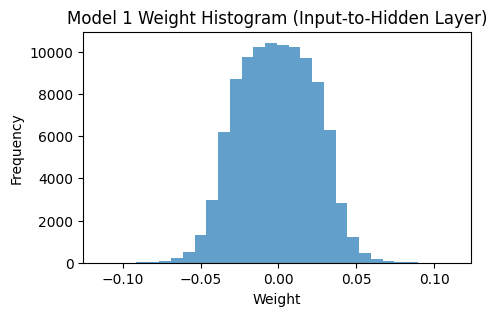

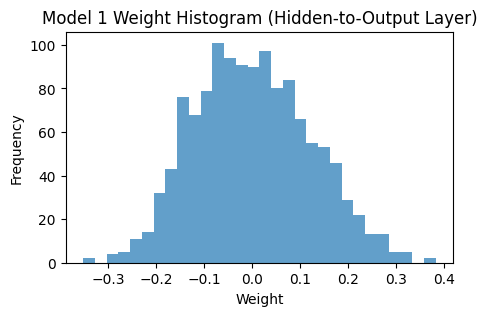

In [127]:
print("Model 1 Weight Histograms (128 Neurons, No Dropout)")
plot_weight_histogram(m1.model, 'fc1', 'Model 1 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m1.model, 'out', 'Model 1 Weight Histogram (Hidden-to-Output Layer)')

Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)


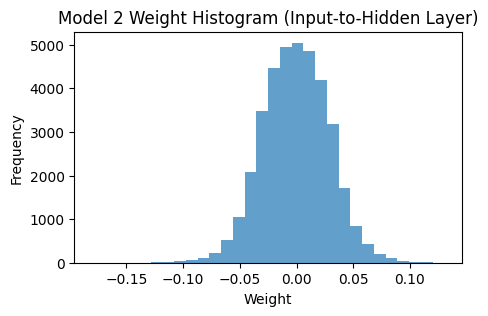

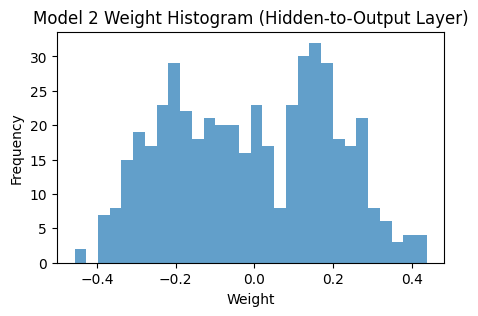

In [128]:
print("Model 2 Weight Histograms (48 Neurons, 20% Dropout, L2 Regularization)")
plot_weight_histogram(m2.model, 'fc1', 'Model 2 Weight Histogram (Input-to-Hidden Layer)')
plot_weight_histogram(m2.model, 'out', 'Model 2 Weight Histogram (Hidden-to-Output Layer)')

In [133]:
# Evaluate models on test data
test_loss1, test_acc1 = m1.evaluate(test_loader)
test_loss2, test_acc2 = m2.evaluate(test_loader)

print(f"Model 1 Test Accuracy: {test_acc1:.4f}")
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")


Model 1 Test Accuracy: 0.8488
Model 2 Test Accuracy: 0.8433


## Back Propagation Algorithm

In [116]:
optimizers = { 
    'Adam': optim.Adam, 
    'NAdam': optim.NAdam, 
    'RMSprop': optim.RMSprop
}
table = []
results = {}
h1 = 100
do_rate = 0.2

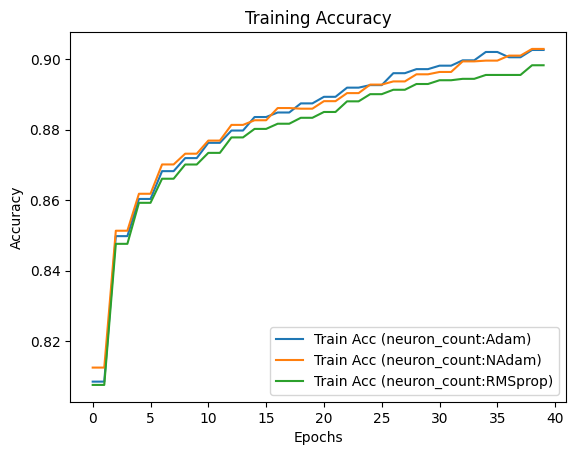

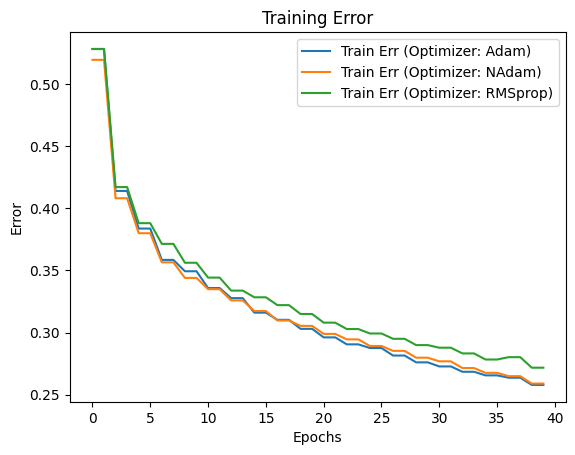

+--------------------+----------+-------+
| Optimizer Analysis | Accuracy | Loss  |
+--------------------+----------+-------+
|     Train-Adam     |  0.903   | 0.258 |
|     Test-Adam      |  0.880   | 0.356 |
|    Train-NAdam     |  0.903   | 0.259 |
|     Test-NAdam     |  0.880   | 0.362 |
|   Train-RMSprop    |  0.898   | 0.272 |
|    Test-RMSprop    |  0.879   | 0.370 |
+--------------------+----------+-------+


In [ ]:
test_loss, test_acc = 0, 0
for name, optimizer in optimizers.items():
    mlp = MLP(Model(h1, do_rate=do_rate), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.compile(optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=20)    
    table += [
        [f'Train-{name}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{name}', format(test_acc), format(test_loss)]
    ]
    results[name] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }
    print(f"Test Result for {name} Optmizer")
    print(f"Test Loss: {test_loss:.4f}")
    print(classification_report(mlp.all_labels, mlp.all_preds, target_names=class_names, zero_division=0))

plot_curve(results, 'train_accuracy', 
            label=f'Train Acc ([Optimizer]:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (Optimizer: ', 
            y_label='Error', title='Training Error')

print(tabulate(table, headers=["Optimizer Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

## Analysis of Different Hyperparameters

In [88]:
def accuracy_on(labels, outputs, title):
    acc = accuracy_score(labels, outputs)
    return [title, acc]

def format(accuracy): 
    return f"{accuracy:.3f}"

def plot_curve(results, what, label, y_label, title):
    for metric, history in results.items():
        data = history[what]
        plt.plot(data, label=label+f'{metric})')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

In [65]:
class Model(nn.Module):
    def __init__(self, h1, do_rate=0, in_features=28*28, out_features=10):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(do_rate)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        # x = self.flatten(x)
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [66]:
class MLP():
    def __init__(self, model, criteria, lambda_reg=0, learning_rate=0.001):
        self.model = model
        self.criteria = criteria
        self.lambda_reg = lambda_reg
        self.learning_rate = learning_rate
        self.optimizer = None 
        self.train_losses, self.train_accuracies = [], []

    def forward(self, images, labels):
        # Forward pass
        outputs = self.model(images)
        loss = self.criteria(outputs, labels)
        return outputs, loss

    def apply_l2_regularization(self):
        l2_reg = 0
        for param in self.model.parameters():
            l2_reg += torch.sum(param ** 2)
        return self.lambda_reg * l2_reg

    def evaluate(self, loader):
        self.model.to(device)
        self.model.eval()
        self.all_preds = []
        self.all_labels = []
        running_loss = 0.0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs, loss = self.forward(images, labels)
                loss += self.apply_l2_regularization()

                running_loss += loss.item() * images.size(0)  # is the batch size
                _, predicted = torch.max(outputs, dim=1)
                self.all_preds.extend(predicted.cpu().detach().numpy())
                self.all_labels.extend(labels.cpu().detach().numpy())

        return ((running_loss / len(loader.dataset))), accuracy_score(self.all_labels, self.all_preds)

    def train_with_optimizer(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            # Reset gradients
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc
    
    def train(self, loader):
        self.model.to(device)
        self.criteria.to(device)
        self.model.train()
        all_preds = []
        all_labels = []
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, loss = self.forward(images, labels)
            loss += self.apply_l2_regularization()
            
            for param in self.model.parameters():
                if param.grad is not None:
                    param.grad.zero_()

            loss.backward()

            with torch.no_grad():
                for param in self.model.parameters():
                    if param.grad is not None:
                        param -= self.learning_rate * param.grad
                    
            running_loss += loss.item() * images.size(0)  # is the batch size
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        return epoch_loss, epoch_acc

    def test(self, loader):
        return self.evaluate(loader)
    
    def compile(self, optimizer, train_loader, test_loader, num_epochs):
        self.optimizer = optimizer(self.model.parameters(), self.learning_rate) # optim.SGD(self.model.parameters(), lr=self.learning_rate)
        train_hist, test_hist = [], []
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_with_optimizer(train_loader)
            train_hist.append({"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc})

        test_loss, test_acc = self.evaluate(test_loader)
        test_hist.append({"test_loss": test_loss, "test_acc": test_acc})
        return train_hist, test_hist
    
    def fit(self, train_loader, test_loader, num_epochs):
        for _ in range(num_epochs):
            train_loss, train_acc = self.train(train_loader)
            self.train_accuracies.append(train_acc)
            self.train_losses.append(train_loss)

        return self.evaluate(test_loader)


In [67]:
dropout_rates = [0.2, 0.4, 0.8]
learning_rates = [0.001, 0.01, 0.1]
lambda_regs = [0.0001, 0.001, 0.01]
hidden_layer_neuron_counts = [32, 64, 128]


#### Dropout Rate Analysis

In [68]:
h1= 128
results = {}
table = []

test_loss, test_acc = 0, 0
for do_rate in dropout_rates:
    mlp = MLP(Model(h1, do_rate=do_rate), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=20)
    table += [
        [f'Train-{do_rate}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{do_rate}', format(test_acc), format(test_loss)]
    ]
    results[do_rate] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }

In [69]:
print(tabulate(table, headers=["Dropout Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+------------------+----------+-------+
| Dropout Analysis | Accuracy | Loss  |
+------------------+----------+-------+
|    Train-0.2     |  0.839   | 0.459 |
|     Test-0.2     |  0.832   | 0.464 |
|    Train-0.4     |  0.828   | 0.484 |
|     Test-0.4     |  0.829   | 0.469 |
|    Train-0.8     |  0.776   | 0.643 |
|     Test-0.8     |  0.816   | 0.505 |
+------------------+----------+-------+


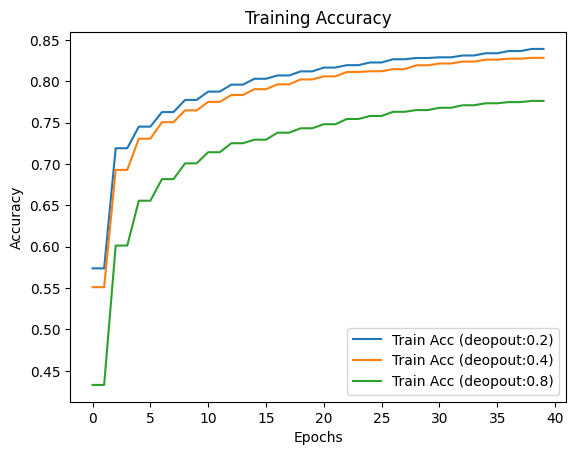

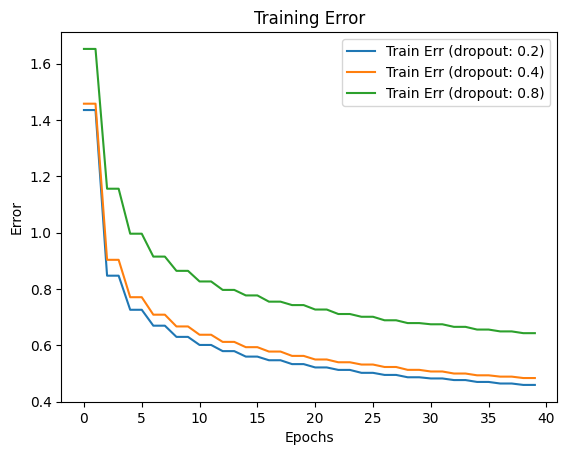

In [ ]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (neuron_count:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (neuron_count: ', 
            y_label='Error', title='Training Error')

#### Neuron Count Analysis

In [91]:
results = {}
table = []

test_loss, test_acc = 0, 0
for neuron_count in hidden_layer_neuron_counts:
    mlp = MLP(Model(neuron_count, do_rate=0.4), nn.CrossEntropyLoss())
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=20)
    table += [
        [f'Train-{neuron_count}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{neuron_count}', format(test_acc), format(test_loss)]
    ]
    results[neuron_count] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }

In [92]:
print(tabulate(table, headers=["Neuron Count Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+-----------------------+----------+-------+
| Neuron Count Analysis | Accuracy | Loss  |
+-----------------------+----------+-------+
|       Train-32        |  0.787   | 0.614 |
|        Test-32        |  0.817   | 0.510 |
|       Train-64        |  0.821   | 0.522 |
|        Test-64        |  0.823   | 0.480 |
|       Train-128       |  0.831   | 0.482 |
|       Test-128        |  0.830   | 0.470 |
+-----------------------+----------+-------+


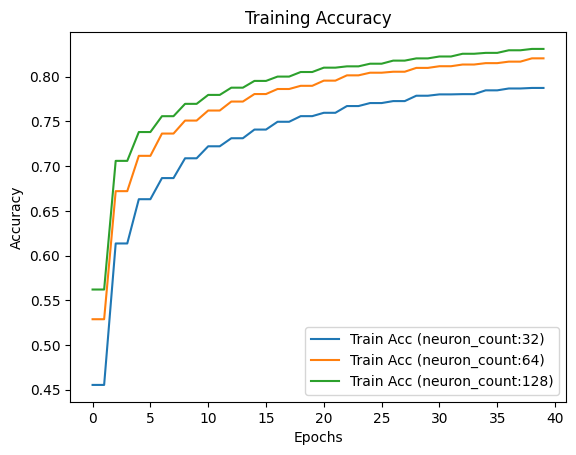

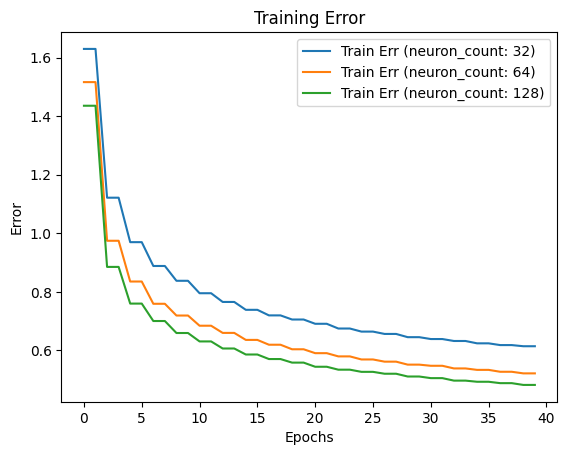

In [93]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (neuron_count:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (neuron_count: ', 
            y_label='Error', title='Training Error')

#### Learning Rate Analysis

In [94]:
results = {}
table = []

test_loss, test_acc = 0, 0
for lr in learning_rates:
    mlp = MLP(Model(128, do_rate=0.4), nn.CrossEntropyLoss(), learning_rate=lr)
    test_loss, test_acc = mlp.fit(train_loader, test_loader, num_epochs=20)
    table += [
        [f'Train-{lr}', format(mlp.train_accuracies[-1]), format(mlp.train_losses[-1])],
        [f'Test-{lr}', format(test_acc), format(test_loss)]
    ]
    results[lr] = {
        'train_accuracy': mlp.train_accuracies,
        'train_loss': mlp.train_losses
    }

In [95]:
print(tabulate(table, headers=["Learning Rate Analysis", "Accuracy", "Loss"], tablefmt="pretty"))

+------------------------+----------+-------+
| Learning Rate Analysis | Accuracy | Loss  |
+------------------------+----------+-------+
|      Train-0.001       |  0.832   | 0.482 |
|       Test-0.001       |  0.832   | 0.468 |
|       Train-0.01       |  0.882   | 0.329 |
|       Test-0.01        |  0.876   | 0.349 |
|       Train-0.1        |  0.881   | 0.322 |
|        Test-0.1        |  0.873   | 0.370 |
+------------------------+----------+-------+


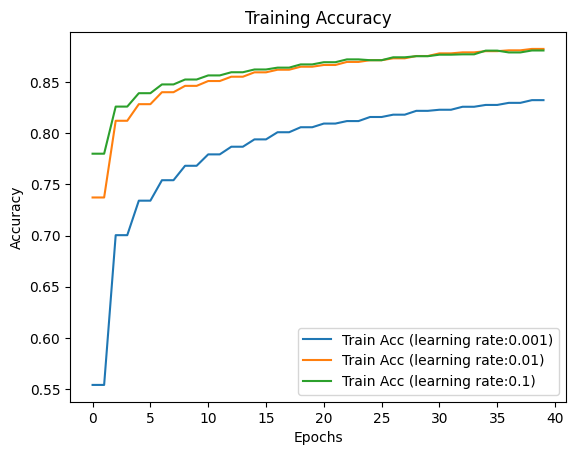

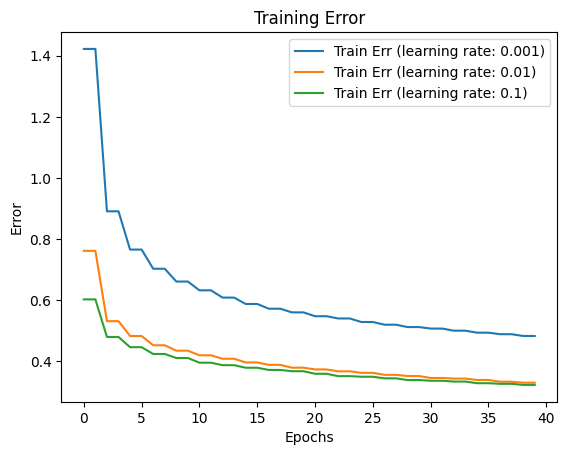

In [96]:
plot_curve(results, 'train_accuracy', 
            label=f'Train Acc (learning rate:', 
            y_label='Accuracy', title='Training Accuracy')

plot_curve(results, 'train_loss', 
            label=f'Train Err (learning rate: ', 
            y_label='Error', title='Training Error')

<!-- - [Ref1]()
- [Ref2]()
- [Ref3]() -->

<!--  -->